In [2]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import pandas as pd
import csv
import tempfile
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
import seaborn as sns
import glob
from skimage.transform import resize
import seaborn as sns


In [3]:
raw_1 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat33/Pat33_CHU.nii.gz'
raw_2 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat33/Pat33_COL.nii.gz'

prepro_1 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat33/Pat33_CHU_zscore_minmax_unbias.nii.gz'
prepro_2 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat33/Pat33_COL_zscore_minmax_unbias.nii.gz'

mask = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat33/Pat33_CHU_mask.nii.gz'

In [4]:
def bland_altman_plot_final(data1, data2, maskfile, save_path=None):
    
    downsample_factor=15
    
    image1 = nib.load(data1).get_fdata()[::downsample_factor,::downsample_factor,::downsample_factor]
    image2 = nib.load(data2).get_fdata()[::downsample_factor,::downsample_factor,::downsample_factor]
    mask = nib.load(maskfile).get_fdata()[::downsample_factor,::downsample_factor,::downsample_factor]
    
    mean = (image1 + image2) / 2
    diff = image1 - image2

    mean_diff = np.mean(diff[mask>0])
    std_diff = np.std(diff[mask>0], ddof=1)
    lower_limit = mean_diff - 1.96 * std_diff
    upper_limit = mean_diff + 1.96 * std_diff

    plt.figure(figsize=(8, 6))
    plt.scatter(mean[mask>0], diff[mask>0], c='b', alpha=0.5, s=30)
    plt.axhline(mean_diff, color='red', linestyle='--', linewidth=2)
    plt.axhline(lower_limit, color='green', linestyle='--', linewidth=1)
    plt.axhline(upper_limit, color='green', linestyle='--', linewidth=1)
    plt.xlabel('Moyenne des deux mesures')
    plt.ylabel('Différence entre les mesures')
    plt.title('Bland-Altman Plot')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    
    points_within_limits = np.sum((diff[mask>0] >= lower_limit) & (diff[mask>0] <= upper_limit))
    all_points = np.sum(mask>0)

    return print(f"Number of points within Bland-Altman limits: {points_within_limits} / {all_points}")

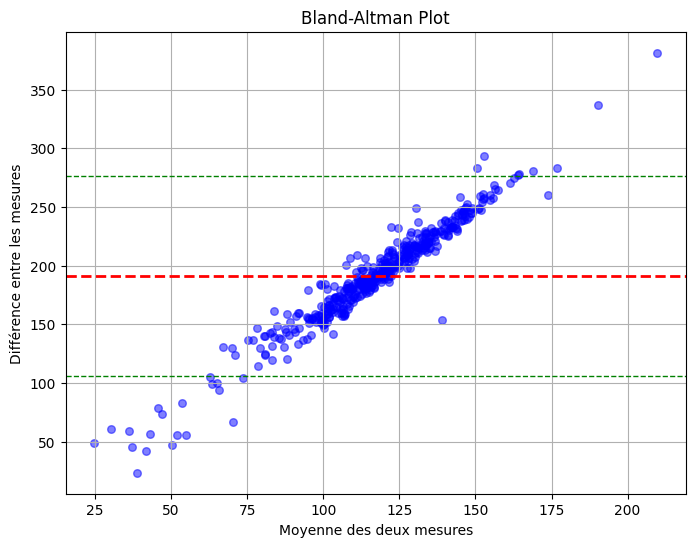

Number of points within Bland-Altman limits: 425 / 452


In [69]:
save_path = '/home/youssef/Downloads/Graphics/bland_altman_plot_raw.png'
bland_altman_plot_final(raw_1, raw_2, mask, save_path)

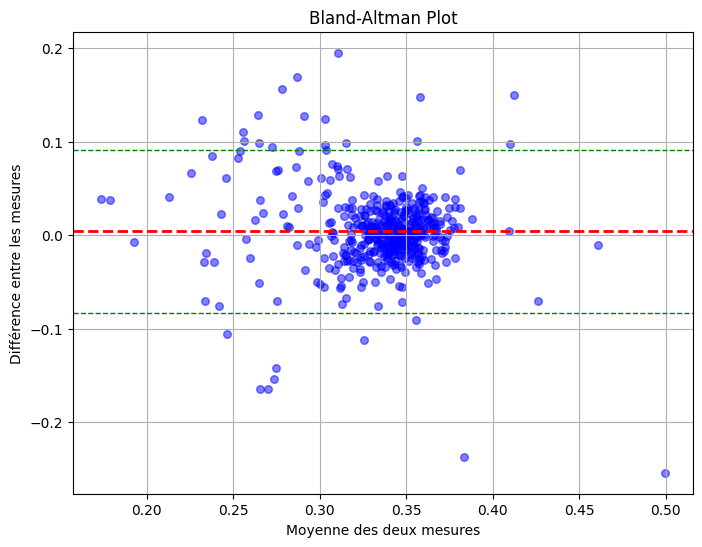

Number of points within Bland-Altman limits: 425 / 452


In [70]:
save_path = '/home/youssef/Downloads/Graphics/bland_altman_plot_prepro.png'
bland_altman_plot_final(prepro_1, prepro_2, mask, save_path)

In [24]:
def pearson_correlation(data1, data2, maskfile, save_path=None):
    # Load NIfTI images and mask
    downsample_factor=15
    
    image1 = nib.load(data1).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    image2 = nib.load(data2).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    mask = nib.load(maskfile).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]

    image1_mask = image1[mask > 0]
    image2_mask = image2[mask > 0]

    correlation_coefficient, _ = pearsonr(image1_mask, image2_mask)

    plt.figure(figsize=(8, 6))
    sns.regplot(x=image1_mask, y=image2_mask, scatter_kws={'alpha':0.5}, color="m")
    
    plt.title("Scatter Plot")
    plt.xlabel("GE SIGNA 1.5T")
    plt.ylabel("Siemens SOLA 1.5T")
    plt.text(
        np.min(image1_mask), np.max(image2_mask),
        f"Pearson Correlation: {correlation_coefficient:.2f}",
        fontsize=12,
        color='red'
    )
    
    
    plt.grid()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

    return correlation_coefficient

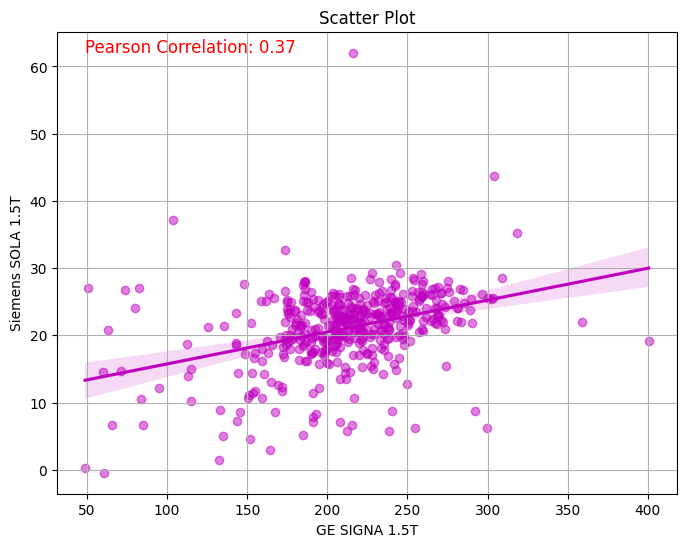

Pearson Correlation Coefficient : 0.3713200128491554


In [25]:
save_path = '/home/youssef/Downloads/Graphics/Pearson correlation_raw.png'
print("Pearson Correlation Coefficient :", pearson_correlation(raw_1, raw_2, mask, save_path))

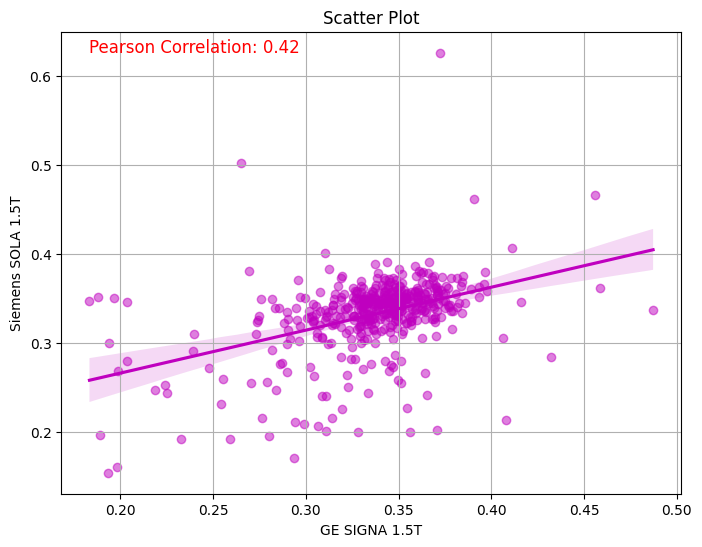

Pearson Correlation Coefficient : 0.421726045873543


In [26]:
save_path = '/home/youssef/Downloads/Graphics/Pearson correlation_prepro.png'
print("Pearson Correlation Coefficient :", pearson_correlation(prepro_1, prepro_2, mask, save_path))

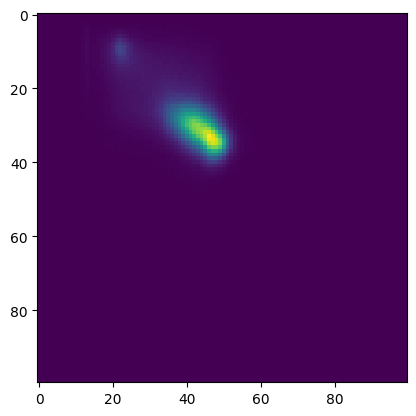

In [28]:
raw_1 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_CHU.nii.gz'
raw_2 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_COL.nii.gz'
mask = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_CHU_mask.nii.gz'

image1 = nib.load(raw_1).get_fdata()
image2 = nib.load(raw_2).get_fdata()
mask1 = nib.load(mask).get_fdata()

image1_mask = image1[mask1 > 0]
image2_mask = image2[mask1 > 0]

test=np.histogram2d(image1_mask,image2_mask,bins=100)[0]
plt.imshow(test)

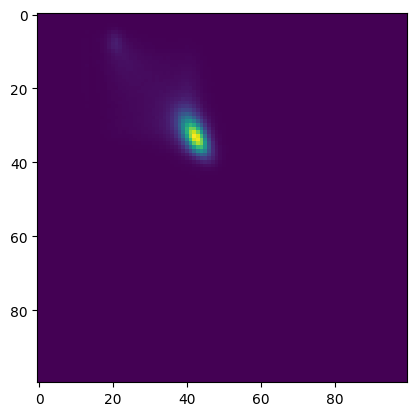

In [29]:
prepro_1 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_CHU_zscore_minmax_unbias.nii.gz'
prepro_2 = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_COL_zscore_minmax_unbias.nii.gz'

mask = '/NAS/dumbo/protocoles/HAMSI/OurData4Mispel_T1Gado/data4PDDM/Pat8/Pat8_CHU_mask.nii.gz'

image1 = nib.load(prepro_1).get_fdata()
image2 = nib.load(prepro_2).get_fdata()
mask1 = nib.load(mask).get_fdata()

image1_mask = image1[mask1 > 0]
image2_mask = image2[mask1 > 0]

test=np.histogram2d(image1_mask,image2_mask,bins=100)[0]
plt.imshow(test)

In [43]:
# Calculez la probabilité marginale
p_joint = np.histogram2d(image1_mask, image2_mask, bins=256, density=True)
p_x = np.histogram(image1_mask, bins=256, density=True)[0]
p_y = np.histogram(image2_mask, bins=256, density=True)[0]
information_mutual = np.sum(p_joint[0] * np.log2(p_joint[0] / (p_x * p_y)))
print(information_mutual)

nan


/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


In [94]:
def mutual_information(data1, data2, maskfile, save_path=None):
    # Load NIfTI images and mask
    downsample_factor = 15
    
    image1 = nib.load(data1).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    image2 = nib.load(data2).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    mask = nib.load(maskfile).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Apply mask to the images
    image1_mask = image1[mask > 0]
    image2_mask = image2[mask > 0]

    # Calculate mutual information
    mutual_info = mutual_info_score(image1_mask, image2_mask)

    # Create a scatter plot with a regression line and color differentiation based on mutual information
    plt.figure(figsize=(8, 6))
    scatter_plot = sns.regplot(
        x=image1_mask, y=image2_mask, 
        scatter_kws={'alpha': 0.5}, color='g', 
        line_kws={'color': 'red'}  # You can specify other line properties here
    )
    
    plt.title("Scatter Plot")
    plt.xlabel("GE SIGNA 1.5T")
    plt.ylabel("Siemens SOLA 1.5T")
    plt.text(
        np.min(image1_mask), np.max(image2_mask),
        f"Mutual Information: {mutual_info:.2f}",
        fontsize=12,
        color='green'
    )
    plt.grid()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

    return mutual_info

In [21]:
def mutual_information_hist(data1, data2, maskfile, save_path=None):
    
    downsample_factor = 1
    
    image1 = nib.load(data1).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    image2 = nib.load(data2).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]
    mask = nib.load(maskfile).get_fdata()[::downsample_factor, ::downsample_factor, ::downsample_factor]

    image1_mask = image1[mask > 0]
    image2_mask = image2[mask > 0]

    mutual_info = mutual_info_score(image1_mask, image2_mask)

    joint_hist = np.histogram2d(image1_mask, image2_mask, bins=100)[0]
    plt.imshow(joint_hist)

    plt.title("Histogramme conjoint")
    plt.xlabel("GE SIGNA 1.5T")
    plt.ylabel("Siemens SOLA 1.5T")

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

    return mutual_info

In [22]:
save_path = '/home/youssef/Downloads/Graphics/Mutual_information_raw.png'
mutual_info_result = mutual_information_hist(raw_1, raw_2, mask, save_path)

/home/youssef/.local/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [23]:
save_path = '/home/youssef/Downloads/Graphics/Mutual_information_prepro.png'
mutual_info_result = mutual_information_hist(prepro_1, prepro_2, mask, save_path)

/home/youssef/.local/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
